In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols, sqrt, Eq
#import decimal as d

import invariants.functions as f
from invariants.solidly import SolidlyInvariant, SolidlySwapFunction

from testing import *
#D = d.Decimal
plt.rcParams['figure.figsize'] = [6,6]

print("---")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(f.Function))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(SolidlyInvariant))

imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require, Timer
---
Function v0.9.6 (26/Jan/2024)
SolidlyInvariant v0.9 (18/Jan/2024)


# Solidly Analysis -- Notebook 2

## Introduction

### Invariant function

The Solidly invariant function is a stable swap curve

$$
    f(x,y) = x^3y+xy^3 = k
$$

### Swap equation

Solving the invariance equation as $y=y(x; k)$ gives the following result for what we want to call the **swap equation**

$$
y(x; k) = \frac{x^2}{\sqrt[3]{L(x; k)}} - \frac{\sqrt[3]{L(x;k)}}{3}
$$

$$
L(x;k) = -\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}
$$

Using the function $y(x;k)$ we can easily derive the **actual swap equation** at point $(x; k)$ as

$$
\Delta y = y(x+\Delta x; k) - y(x; k)
$$

#### Precision issues and L

The above form of L -- that we want to denote $L_1$ -- is numerically not well conditioned for small $x$. In order to improve conditioning we rewrite $L$ into the format $L_2$ below

$$
L_2(x;k) = \frac{27k}{2x} \left(\sqrt{1 + \frac{108x^8}{729k^2}} - 1 \right)
$$

We note that for small $x$ the Taylor development below gives better results than finite precision numerics

$$
\sqrt{1+\xi}-1 = \frac{\xi}{2} - \frac{\xi^2}{8} + \frac{\xi^3}{16} - \frac{5\xi^4}{128} + O(\xi^5)
$$

### Price equation

The derivative $p=dy/dx$ -- the **price equation** -- can be determined analytically but its complexity is such that perturbative calculation is preferrable. Importantly, we do not have how to invert it (ie write $x=x(p)$, which creates complications for our preferred method of optimization, the _marginal price optimization_.


## Analysing the invariance curve

### Overall shape in real space

Here we draw the invariance curves for difference values of $k$ (or $\sqrt[4]{k}$ which is the quantity that scales linearly with currency amounts; see the notes in the first notebook regarding the scaling properties of the equation and its implications). More specifically we draw

- the **invariance curves** for various values of $\sqrt[4]{k}$ 

- their **central tangents**, showing the curves are very flat in the core region, and finally

- the **boundary rays** of the different regimes of the equation

In [2]:
k_sqrt4_v = [2, 4, 6, 8]
k_v = [kk**4 for kk in k_sqrt4_v]

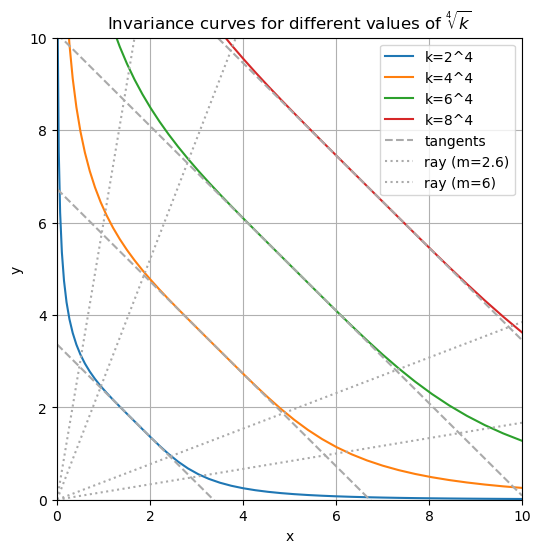

In [3]:
x_v = np.linspace(0, m.sqrt(10), 50)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2

# draw the invariance curves
for kk in k_v: 
    y_f = SolidlySwapFunction(k=kk)
    yy_v = [y_f(xx) for xx in x_v]
    #yy_v = [y_f(xx, kk) for xx in x_v]
    plt.plot(x_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")

# draw the central tangents
C = 0.5**(0.25)
label="tangents"
for kk in k_sqrt4_v:
    yy_v = [C*kk - (xx-C*kk) for xx in x_v]
    plt.plot(x_v, yy_v, marker=None, linestyle='--', color="#aaa", label=label)
    label = ""

# draw the rays
for mm in [2.6, 6]:
    yy_v = [mm*xx for xx in x_v]
    plt.plot(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
    yy_v = [1/mm*xx for xx in x_v]
    plt.plot(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa")

plt.grid(True)
plt.legend()
plt.xlim(0, max(x_v))
plt.ylim(0, max(x_v))
plt.title("Invariance curves for different values of $\sqrt[4]{k}$")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/skl/Desktop/image.jpg")
plt.show()

### In log/log space

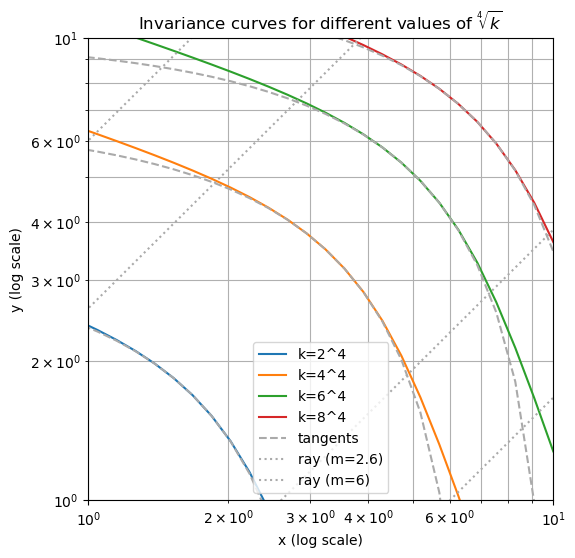

In [4]:
x_log_v = np.linspace(-m.log(10), m.log(10), 50)

# draw the invariance curves
k_v = [kk**4 for kk in k_sqrt4_v]
x_v = [m.exp(xx) for xx in x_log_v]

for kk in k_v: 
    y_f = SolidlySwapFunction(k=kk)
    yy_v = [y_f(xx) for xx in x_v]
    #yy_v = [y_f(xx, kk) for xx in x_v]
    plt.loglog(x_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")

# draw the central tangents
C = 0.5**(0.25)
label="tangents"
for kk in k_sqrt4_v:
    yy_v = [C*kk - (xx-C*kk) for xx in x_v]
    plt.loglog(x_v, yy_v, marker=None, linestyle='--', color="#aaa", label=label)
    label = ""

# draw the rays
for mm in [2.6, 6]:
    yy_v = [mm*xx for xx in x_v]
    plt.loglog(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
    yy_v = [1/mm*xx for xx in x_v]
    plt.loglog(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa")

plt.grid(True, which="both")
plt.legend()
plt.xlim(1, max(x_v))
plt.ylim(1, max(x_v))
plt.title("Invariance curves for different values of $\sqrt[4]{k}$")
plt.xlabel("x (log scale)")
plt.ylabel("y (log scale)")
plt.show()

### As function of x/y, real space

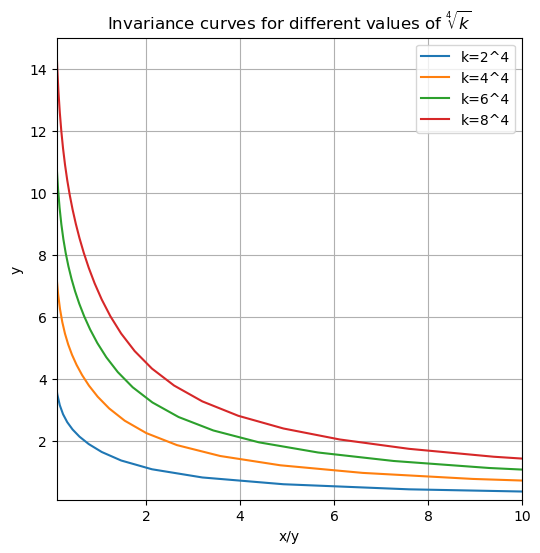

In [5]:
x_v = np.linspace(0, 10, 100)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2

# draw the invariance curves
for kk in k_v: 
    y_f = SolidlySwapFunction(k=kk)
    yy_v = np.array([y_f(xx) for xx in x_v])
    #yy_v = [y_f(xx, kk) for xx in x_v]
    plt.plot(x_v/yy_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")
    #plt.loglog(x_v/yy_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")

# # draw the central tangents
# C = 0.5**(0.25)
# label="tangents"
# for kk in k_sqrt4_v:
#     yy_v = np.array([C*kk - (xx-C*kk) for xx in x_v])
#     plt.plot(yy_v/x_v, yy_v, marker=None, linestyle='--', color="#aaa", label=label)
#     label = ""

# # draw the rays
# for mm in [2.6, 6]:
#     yy_v = [mm*xx for xx in x_v]
#     plt.plot(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
#     yy_v = [1/mm*xx for xx in x_v]
#     plt.plot(y_v/x_v, yy_v, marker=None, linestyle='dotted', color="#aaa")

plt.grid(True)
plt.legend()
plt.xlim(.1, 10)
plt.ylim(.1, 15)
plt.title("Invariance curves for different values of $\sqrt[4]{k}$")
plt.xlabel("x/y")
plt.ylabel("y")
plt.show()

### As function of x/y, log/log

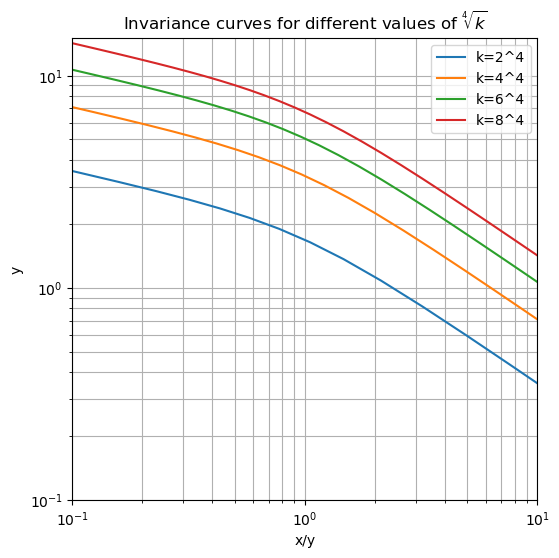

In [6]:
x_v = np.linspace(0, 10, 100)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2

# draw the invariance curves
for kk in k_v: 
    y_f = SolidlySwapFunction(k=kk)
    yy_v = np.array([y_f(xx) for xx in x_v])
    #yy_v = [y_f(xx, kk) for xx in x_v]
    #plt.plot(x_v/yy_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")
    plt.loglog(x_v/yy_v, yy_v, marker=None, linestyle='-', label=f"k={kk**0.25:.0f}^4")

# # draw the central tangents
# C = 0.5**(0.25)
# label="tangents"
# for kk in k_sqrt4_v:
#     yy_v = np.array([C*kk - (xx-C*kk) for xx in x_v])
#     plt.plot(yy_v/x_v, yy_v, marker=None, linestyle='--', color="#aaa", label=label)
#     label = ""

# # draw the rays
# for mm in [2.6, 6]:
#     yy_v = [mm*xx for xx in x_v]
#     plt.plot(x_v, yy_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
#     yy_v = [1/mm*xx for xx in x_v]
#     plt.plot(y_v/x_v, yy_v, marker=None, linestyle='dotted', color="#aaa")

plt.grid(True, which="both")
plt.legend()
plt.xlim(.1, 10)
plt.ylim(.1, 15)
plt.title("Invariance curves for different values of $\sqrt[4]{k}$")
plt.xlabel("x/y")
plt.ylabel("y")
plt.show()

## Fitting a hyperbolic curve

_this code seems to have some issues and we may revisit it later_

In [7]:
k = 5**4

### Determining the central region

The central region is between the rays $m=2.6$ and $1/m=2.6$ (fan-shaped area in the real plot, and diagonal band in the log/log plot). We are fixing $k=5^4$ as a curve in the middle of our existing chart. The inner region in this case is determined by the equations $\frac x y = m$ and $f(x,y)=k$

In [8]:
# x_mid = (k/2)**0.25
# # set up the invariant and the swap function
# iv = SolidlyInvariant()
# y_f = SolidlySwapFunction(k=k)
# ratio_f = lambda x: y_f(x)/x

# # various consistency checks
# print("x,y mid = (k/2)^0.25 = ", x_mid)
# assert iseq(y_f(x_mid), x_mid)  # at x_mid, y_mid = y(x_mid)
# assert iseq(ratio_f(x_mid), 1)  # ditto, but with ratio_f
# assert iseq(f.goalseek(func=ratio_f, target = 1), x_mid) # ditto, but goalseek
# for xx in np.linspace(0.1, 10):
#     assert iseq(iv.k_func(xx, y_f(xx)), k)

# y_f.plot(0.1,10, show=False)
# plt.grid(True)
# plt.xlim(0, 10)
# plt.ylim(0, 10)
# plt.title(f"Invariance curve for $k={k**0.25:.0f}^4$")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

In [9]:
# x_v = np.linspace(0.1,10)
# #plt.plot(x_v, [m.log10(ratio_f(xx)) for xx in x_v])
# plt.plot(x_v, [(ratio_f(xx)) for xx in x_v])
# plt.grid(True)
# plt.xlim(0, 10)
# plt.ylim(0, 5)
# plt.title(f"Ratio y/x for $k={k**0.25:.0f}^4$")
# plt.xlabel("x")
# plt.ylabel("y(x)/x")
# print(f"check that ratio = 1 for x = x_mid = {x_mid}")
# plt.show()

Here we finally determine the **central region**, defined by $m^{\pm 1} = 2.6$. We find that, for our chosen value of $k$, the region is from 2.35 to 6.13 and centers at 4.2.

More generally, scaling laws and experiments show that **in percentage terms this region is independent of k**. In other words, the central region is always

    0.56 x_mid (43.9% below) ... 1.46 x_mid (46.0% above)

In [10]:
# assert iseq(f.goalseek(func=ratio_f, target = 1), x_mid)
# r = (
#     f.goalseek(func=ratio_f, target = 2.6),
#     f.goalseek(func=ratio_f, target = 1),
#     f.goalseek(func=ratio_f, target = 1/2.6)
# )
# r, tuple(round(vv/r[1]*100-100,1) for vv in r), tuple(round(vv/r[1]*100,1) for vv in r)

Here we are asserting invariance with respect to $k$

In [11]:
# k_v = [kk**4 for kk in [5, 25, 100, 1000]]
# for kk in k_v:
#     x_mid = (kk/2)**0.25
#     y_f = SolidlySwapFunction(k=kk)
#     ratio_f = lambda x: y_f(x)/x
#     r0 = (
#         f.goalseek(func=ratio_f, target = 2.6),
#         f.goalseek(func=ratio_f, target = 1),
#         f.goalseek(func=ratio_f, target = 1/2.6)
#     )
#     r = tuple(round(vv/r0[1],4) for vv in r0)
#     print(r)
# x_min_r, _, x_max_r = r

### Fitting with flat kernel

In [12]:
# x_mid = (k/2)**0.25
# x_min, x_max = x_min_r*x_mid, x_max_r*x_mid
# # x_min, x_max = 0.2*x_min, 3*x_max # uncomment to see bigger plot
# k**0.25, x_min, x_mid, x_max 

In [13]:
# iv = SolidlyInvariant()
# y_f = SolidlySwapFunction(k=k)
# fv = f.FunctionVector(kernel=f.Kernel(x_min=x_min, x_max=x_max, kernel=f.Kernel.FLAT))
# y_fv = fv.wrap(y_f)
# y_fv.plot(steps=100, show=False)
# match0_fv = y_fv.wrap(f.HyperbolaFunction(k=15, x0=0, y0=0))
# match0_fv.plot(steps=100, show=False)
# plt.title(f"Invariance function $k={k**0.25:.0f}^4$ (fitted area only)")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

In [14]:
# match0_fv = match0_fv.update(k=25)
# params0 = match0_fv.function().params()
# #del params0["k"]
# params = y_fv.curve_fit(match0_fv.function(), params0, learning_rate=1, iterations=1000, tolerance=0.01, verbose=True)

In [15]:
# match_f = match0_fv.function().update(**params)
# match_fv = y_fv.wrap(match_f)
# y_fv.plot(steps=100, show=False)
# match_fv.plot(steps=100, show=False)
# plt.title(f"Invariance function $k={k**0.25:.0f}^4$ (fitted area only)")
# plt.xlabel("x")
# plt.ylabel("y")
# print("params = ", params)
# print(match_fv.params())
# plt.show()

In [16]:
# iv = SolidlyInvariant()
# y_f = SolidlySwapFunction(k=k)
# fv = f.FunctionVector(kernel=f.Kernel(x_min=x_min, x_max=x_max, kernel=f.Kernel.FLAT))
# y_fv = fv.wrap(y_f)
# y_fv.plot(steps=100, show=False)
# match0_fv = y_fv.wrap(f.QuadraticFunction())
# match0_fv.plot(steps=100, show=False)
# plt.title(f"Invariance function $k={k**0.25:.0f}^4$ (fitted area only)")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

In [17]:
# params0 = match0_fv.function().params()
# params = y_fv.curve_fit(match0_fv.function(), params0, learning_rate=0.1, iterations=100, tolerance=0.01, verbose=True)

## Fitting a hyperbolic curve (charts for paper)

In [18]:
k = 6**4

x_mid = (k/2)**0.25
y_f = SolidlySwapFunction(k=k)
ratio_f = lambda x: y_f(x)/x
r0 = (
    f.goalseek(func=ratio_f, target = 2.6),
    f.goalseek(func=ratio_f, target = 1),
    f.goalseek(func=ratio_f, target = 1/2.6)
)
r = tuple(round(vv/r0[1],4) for vv in r0)
print(r)
x_min_r, _, x_max_r = r
x_min, x_max = x_min_r*x_mid, x_max_r*x_mid
fv_template = f.FunctionVector(kernel=f.Kernel(x_min=x_min, x_max=x_max, kernel=f.Kernel.FLAT))

x_v = np.linspace(0,10,1000)
x_v[0] = x_v[1]/2

k**0.25, x_min, x_mid, x_max 

(0.5611, 1.0, 1.4589)


(6.0, 2.8309618715931557, 5.045378491522287, 7.3607026812818654)

### Generic curve fitting

In [19]:
# solidly
y_fv = fv_template.wrap(y_f)
yy_solidly_v = [y_fv(xx) for xx in x_v]
yp_solidly_v = [y_fv.p(xx) for xx in x_v]
ya = y_f(x_min)

# constant product
ps=0.11
params_opt_L2s = {'k': 4999.920086411355, 'x0': 65.96403685971154, 'y0': 65.36154243491612}
params_opt = {'k': 4999.920086411355, 'x0': 65.96403685971154, 'y0': 65.36154243491612}
match_fv = fv_template.wrap(f.LCPMM.from_xpxp(xa=x_min, xb=x_max, pa=1+ps, pb=1-ps, ya=ya))
match_opt_fv = match_fv.wrap(match_fv.el[0].update(**params_opt))
yy_match_v = [match_fv(xx) for xx in x_v]
yp_match_v = [match_fv.p(xx) for xx in x_v]
yy_match_opt_v = [match_opt_fv(xx) for xx in x_v]
yp_match_opt_v = [match_opt_fv.p(xx) for xx in x_v]

# rays
mm = 2.6
yy_ray1_v = [mm*xx for xx in x_v]
yy_ray2_v = [1/mm*xx for xx in x_v]

# tangent
C = 0.5**(0.25)
kk = k**0.25
yy_tang_v = [C*kk - (xx-C*kk) for xx in x_v]

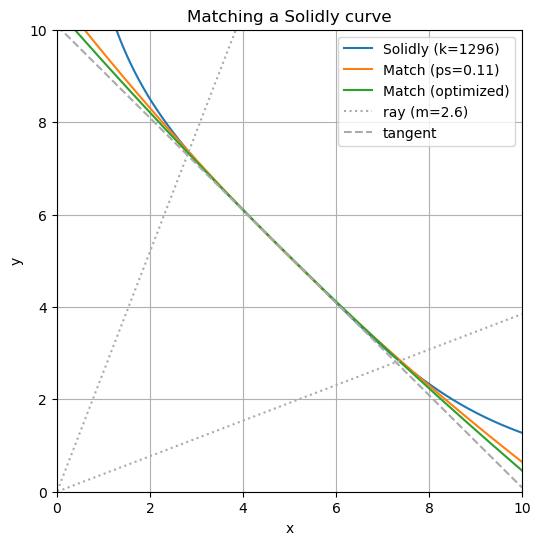

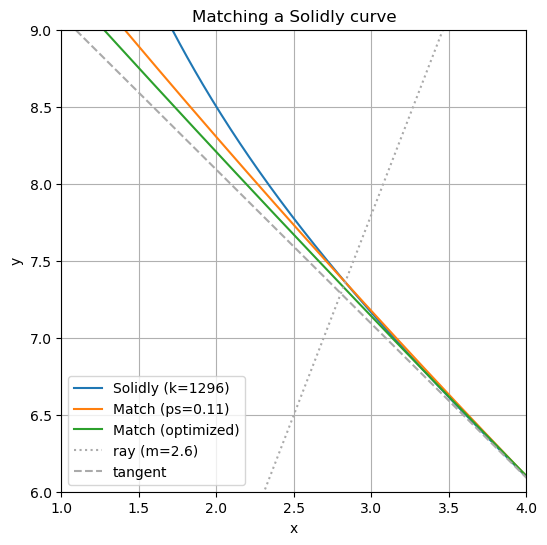

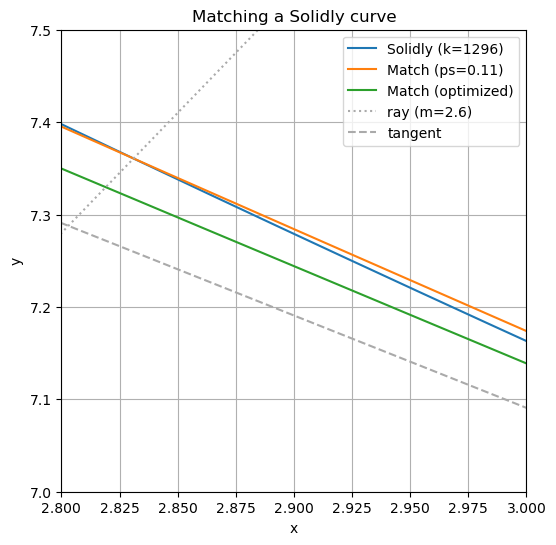

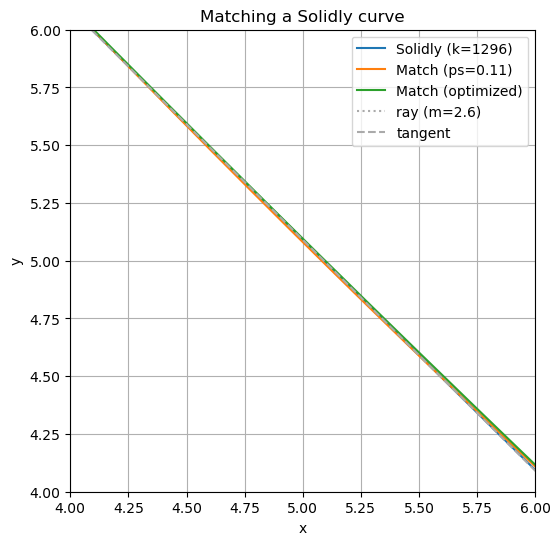

In [20]:
# plot 1
plt.plot(x_v, yy_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yy_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yy_match_opt_v, label=f"Match (optimized)")
plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.savefig("/Users/skl/Desktop/sol_img_matching1.jpg")
plt.show()

# plot 2
plt.plot(x_v, yy_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yy_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yy_match_opt_v, label=f"Match (optimized)")
plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.xlim(1, 4)
plt.ylim(6, 9)
plt.savefig("/Users/skl/Desktop/sol_img_matching2.jpg")
plt.show()

# plot 3
plt.plot(x_v, yy_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yy_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yy_match_opt_v, label=f"Match (optimized)")
plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.xlim(2.8, 3)
plt.ylim(7, 7.5)
plt.savefig("/Users/skl/Desktop/sol_img_matching3.jpg")
plt.show()

# plot 4
plt.plot(x_v, yy_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yy_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yy_match_opt_v, label=f"Match (optimized)")
plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.xlim(4, 6)
plt.ylim(4, 6)
plt.savefig("/Users/skl/Desktop/sol_img_matching4.jpg")
plt.show()

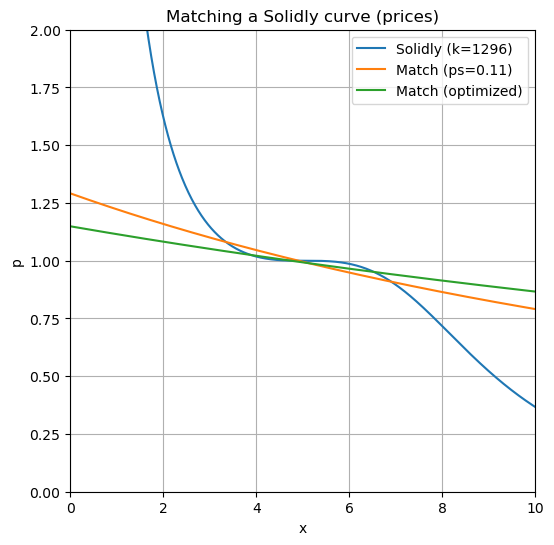

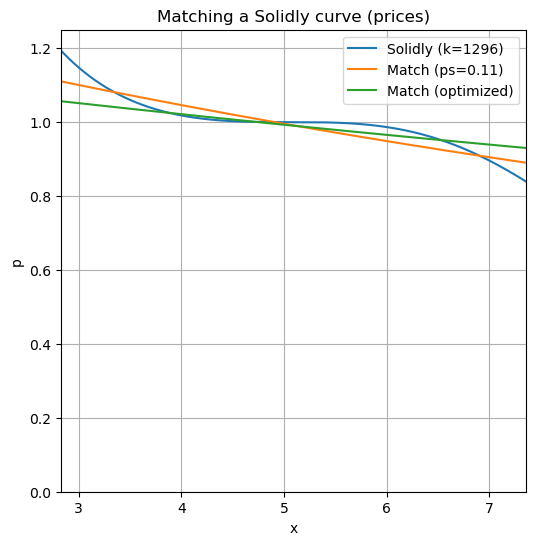

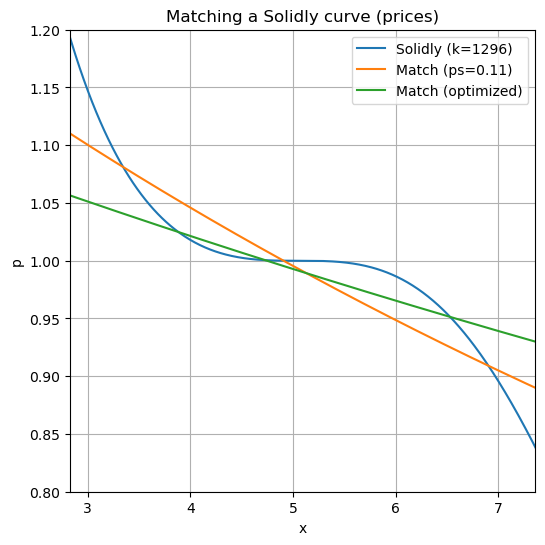

In [21]:
# plot 1
plt.plot(x_v, yp_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yp_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yp_match_opt_v, label=f"Match (optimized)")
# plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
# plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
# plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve (prices)")
plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 2)
plt.savefig("/Users/skl/Desktop/sol_img_matchingp1.jpg")
plt.show()

# plot 2
plt.plot(x_v, yp_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yp_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yp_match_opt_v, label=f"Match (optimized)")
# plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
# plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
# plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve (prices)")
plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(0, 1.25)
plt.savefig("/Users/skl/Desktop/sol_img_matchingp2.jpg")
plt.show()

# plot 3
plt.plot(x_v, yp_solidly_v, label=f"Solidly (k={k})")
plt.plot(x_v, yp_match_v, label=f"Match (ps={ps})")
plt.plot(x_v, yp_match_opt_v, label=f"Match (optimized)")
# plt.plot(x_v, yy_ray1_v, marker=None, linestyle='dotted', color="#aaa", label=f"ray (m={mm})")
# plt.plot(x_v, yy_ray2_v, marker=None, linestyle='dotted', color="#aaa")
# plt.plot(x_v, yy_tang_v, marker=None, linestyle='--', color="#aaa", label="tangent")
plt.grid(True)
plt.title(f"Matching a Solidly curve (prices)")
plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(0.8, 1.2)
plt.savefig("/Users/skl/Desktop/sol_img_matchingp3.jpg")
plt.show()


In [22]:
match1_fv = match_fv.update()
params0 = match1_fv.function().params()
params0 = dict(k=5000, x0=60, y0=60)
print(params0)
params = y_fv.curve_fit(match1_fv.function(), params0, learning_rate=0.5, 
                        iterations=50, tolerance=0.01, verbosity=y_fv.MM_VERBOSITY_LOW)
print(params)

{'k': 5000, 'x0': 60, 'y0': 60}
[minimize] converged in 13 iterations, norm=0.009877
x={'k': 4999.920086411355, 'x0': 65.96403685971154, 'y0': 65.36154243491612})
{'k': 4999.920086411355, 'x0': 65.96403685971154, 'y0': 65.36154243491612}


In [23]:
# params = y_fv.curve_fit(match1_fv.function(), params0, learning_rate=0.5, 
#                         iterations=50, tolerance=0.01, norm=y_fv.CF_NORM_L2S, verbosity=y_fv.MM_VERBOSITY_HIGH)
# print(params)

In [24]:
# params = y_fv.curve_fit(match1_fv.function(), params0, learning_rate=0.01, 
#                         iterations=50, tolerance=0.01, norm=y_fv.CF_NORM_L2, verbosity=y_fv.MM_VERBOSITY_HIGH)
# print(params)

In [25]:
# params = y_fv.curve_fit(match1_fv.function(), params0, learning_rate=0.02, 
#                         iterations=50, tolerance=0.01, norm=y_fv.CF_NORM_L1, verbosity=y_fv.MM_VERBOSITY_HIGH)
# print(params)

### Varying the price spread

In [26]:
fv_flat = f.FunctionVector(kernel=f.Kernel(x_min=x_min, x_max=x_max, kernel=f.Kernel.FLAT))
fv_triang = f.FunctionVector(kernel=f.Kernel(x_min=x_min, x_max=x_max, kernel=f.Kernel.TRIANGLE))

swap curves

In [27]:
# check different price spread curves
ps_v = np.linspace(0,0.15, 100)
ps_v[0] = ps_v[1]/2
dist_flat_l2_ps_v = []
dist_flat_l1_ps_v = []
dist_triang_l2_ps_v = []
dist_triang_l1_ps_v = []
for psps in ps_v:
    psps = max(psps, 0.001)
    match_ps_f = f.LCPMM.from_xpxp(xa=x_min, xb=x_max, pa=1+psps, pb=1-psps, ya=ya)
    match_ps_flat_fv = fv_flat.wrap(match_ps_f)
    match_ps_triang_fv = fv_triang.wrap(match_ps_f)
    dist_flat_l2 = match_ps_flat_fv.dist_L2(y_f)
    dist_flat_l1 = match_ps_flat_fv.dist_L1(y_f)
    dist_triang_l2 = match_ps_triang_fv.dist_L2(y_f)
    dist_triang_l1 = match_ps_triang_fv.dist_L1(y_f)
    #print(psps, dist)
    dist_flat_l2_ps_v.append(dist_flat_l2)
    dist_flat_l1_ps_v.append(dist_flat_l1)
    dist_triang_l2_ps_v.append(dist_triang_l2)
    dist_triang_l1_ps_v.append(dist_triang_l1)


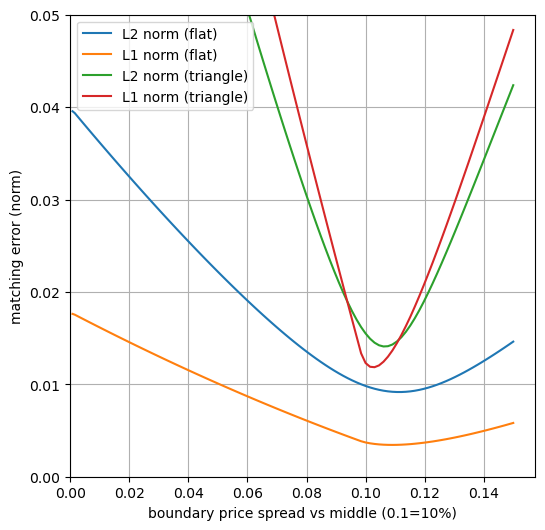

In [28]:
plt.plot(ps_v, dist_flat_l2_ps_v, label="L2 norm (flat)")
plt.plot(ps_v, dist_flat_l1_ps_v, label="L1 norm (flat)")
plt.plot(ps_v, dist_triang_l2_ps_v, label="L2 norm (triangle)")
plt.plot(ps_v, dist_triang_l1_ps_v, label="L1 norm (triangle)")
plt.grid()
plt.xlabel("boundary price spread vs middle (0.1=10%)")
plt.ylabel("matching error on swap function (norm)")
#plt.title("Optimal price spread")
plt.xlim(0,None)
plt.ylim(0,0.05)
plt.legend()
plt.savefig("/Users/skl/Desktop/sol_img_optps.jpg")
plt.show()

price curves

In [30]:
# check different price spread curves
ps_v = np.linspace(0,0.15, 100)
ps_v[0] = ps_v[1]/2
dist_flat_l2_ps_v = []
dist_flat_l1_ps_v = []
dist_triang_l2_ps_v = []
dist_triang_l1_ps_v = []
for psps in ps_v:
    psps = max(psps, 0.001)
    match_ps_f = f.LCPMM.from_xpxp(xa=x_min, xb=x_max, pa=1+psps, pb=1-psps, ya=ya)
    match_ps_flat_fv = fv_flat.wrap(match_ps_f)
    match_ps_triang_fv = fv_triang.wrap(match_ps_f)
    dist_flat_l2 = match_ps_flat_fv.distp_L2(y_f.p)
    dist_flat_l1 = match_ps_flat_fv.distp_L1(y_f.p)
    dist_triang_l2 = match_ps_triang_fv.distp_L2(y_f.p)
    dist_triang_l1 = match_ps_triang_fv.distp_L1(y_f.p)
    #print(psps, dist)
    dist_flat_l2_ps_v.append(dist_flat_l2)
    dist_flat_l1_ps_v.append(dist_flat_l1)
    dist_triang_l2_ps_v.append(dist_triang_l2)
    dist_triang_l1_ps_v.append(dist_triang_l1)


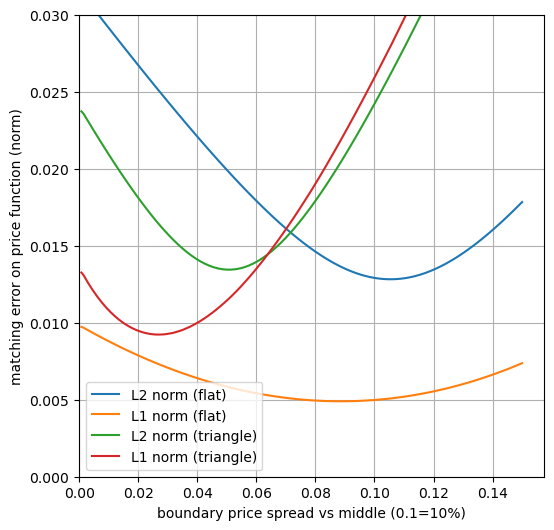

In [32]:
plt.plot(ps_v, dist_flat_l2_ps_v, label="L2 norm (flat)")
plt.plot(ps_v, dist_flat_l1_ps_v, label="L1 norm (flat)")
plt.plot(ps_v, dist_triang_l2_ps_v, label="L2 norm (triangle)")
plt.plot(ps_v, dist_triang_l1_ps_v, label="L1 norm (triangle)")
plt.grid()
plt.xlabel("boundary price spread vs middle (0.1=10%)")
plt.ylabel("matching error on price function (norm)")
#plt.title("Optimal price spread")
plt.xlim(0,None)
plt.ylim(0,0.03)
plt.legend()
plt.savefig("/Users/skl/Desktop/sol_img_optpsp.jpg")
plt.show()